In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [2]:
def normalize_probabilities(df):
    """
    Properly normalize implied probabilities and remove the vig.
    """
    df = df.copy()
    df['implied_prob'] = 1 / df['decimal_odds']
    
    def normalize_game_probs(group):
        total_prob = group['implied_prob'].sum()
        power = 1
        normalized_probs = np.power(group['implied_prob'], power)
        while abs(normalized_probs.sum() - 1) > 0.0001:
            power += 0.0001
            normalized_probs = np.power(group['implied_prob'], power)
            normalized_probs = normalized_probs / normalized_probs.sum()
        
        group['true_probability'] = normalized_probs
        group['removed_vig'] = (total_prob - 1) / len(group)
        return group
    
    df = df.groupby(['game_id', 'bookmaker'], group_keys=False).apply(normalize_game_probs)
    if df.index.names and 'game_id' in df.index.names:
        df = df.reset_index()
    return df

In [3]:
def process_odds_data(raw_data):
    """
    Process raw API data into a structured DataFrame with enhanced tracking.
    """
    processed_data = []
    
    for game in raw_data:
        game_id = game['id']
        commence_time = pd.to_datetime(game['commence_time']).tz_convert('UTC')
        current_time = pd.Timestamp.now(tz='UTC')
        
        all_spreads = defaultdict(list)
        
        for bookmaker in game['bookmakers']:
            for market in bookmaker['markets']:
                if market['key'] == 'spreads':
                    for outcome in market['outcomes']:
                        all_spreads[outcome['name']].append(float(outcome['point']))
                        
                        bet_data = {
                            'game_id': game_id,
                            'timestamp': pd.Timestamp.now(),
                            'commence_time': commence_time,
                            'home_team': game['home_team'],
                            'away_team': game['away_team'],
                            'bookmaker': bookmaker['title'],
                            'team': outcome['name'],
                            'spread': float(outcome['point']),
                            'decimal_odds': float(outcome['price']),
                            'is_home': outcome['name'] == game['home_team'],
                            'time_to_game': (commence_time - current_time).total_seconds() / 3600
                        }
                        processed_data.append(bet_data)
    
        for entry in processed_data:
            if entry['game_id'] == game_id:
                team = entry['team']
                entry['consensus_spread'] = np.median(all_spreads[team])
                entry['spread_diff_from_consensus'] = entry['spread'] - entry['consensus_spread']

    df = pd.DataFrame(processed_data)
    return df

In [4]:
import requests
import pandas as pd
import json
from datetime import datetime, timedelta
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [5]:
def fetch_nba_odds():
    """
    Fetch NBA odds from the API and return the raw data.
    """
    API_KEY = '5da2f5f49f76efd1857a9d71977e184d'
    SPORT = 'basketball_nba'
    
    url = f'https://api.the-odds-api.com/v4/sports/{SPORT}/odds'
    params = {
        'apiKey': API_KEY,
        'regions': 'us',
        'markets': 'spreads',
        'oddsFormat': 'decimal'
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        print(f'Remaining API requests: {response.headers.get("x-requests-remaining")}')
        return response.json()
    else:
        print(f'Error: {response.status_code}')
        return None

In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict

def process_odds_data(raw_data):
    """
    Process raw API data into a structured DataFrame with enhanced tracking.
    """
    processed_data = []
    current_time = pd.Timestamp.now(tz='UTC')  # Define once for consistency

    for game in raw_data:
        game_id = game['id']
        commence_time = pd.to_datetime(game['commence_time']).tz_convert('UTC')

        all_spreads = defaultdict(list)

        for bookmaker in game.get('bookmakers', []):  # Avoid KeyError
            for market in bookmaker.get('markets', []):  # Avoid KeyError
                if market.get('key') == 'spreads':  # Ensure it's spreads data
                    for outcome in market.get('outcomes', []):  # Avoid KeyError
                        all_spreads[outcome['name']].append(float(outcome['point']))

                        consensus_spread = np.median(all_spreads[outcome['name']]) if all_spreads[outcome['name']] else None
                        spread_diff = float(outcome['point']) - consensus_spread if consensus_spread is not None else None

                        bet_data = {
                            'game_id': game_id,
                            'timestamp': pd.Timestamp.now(),  # Still per entry, but consistent with loop
                            'commence_time': commence_time,
                            'home_team': game['home_team'],
                            'away_team': game['away_team'],
                            'bookmaker': bookmaker['title'],
                            'team': outcome['name'],
                            'spread': float(outcome['point']),
                            'decimal_odds': float(outcome['price']),
                            'is_home': outcome['name'] == game['home_team'],
                            'time_to_game': max(0, (commence_time - current_time).total_seconds() / 3600),
                            'consensus_spread': consensus_spread,
                            'spread_diff_from_consensus': spread_diff
                        }

                        processed_data.append(bet_data)

    df = pd.DataFrame(processed_data)
    return df


In [7]:
def analyze_odds_distribution(df):
    """
    Analyze the distribution of odds and spreads across bookmakers.
    """
    analysis = {}
    df = df.copy().reset_index(drop=True)
    
    spread_stats = df.groupby(['game_id', 'team'], as_index=False).agg({
        'spread': ['mean', 'std', 'min', 'max'],
        'decimal_odds': ['mean', 'std', 'min', 'max']
    })
    
    spread_stats.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in spread_stats.columns]
    
    def flag_outliers(group):
        spread_mean = group['spread'].mean()
        spread_std = group['spread'].std()
        if spread_std > 0:
            group['is_spread_outlier'] = abs(group['spread'] - spread_mean) > (2 * spread_std)
        else:
            group['is_spread_outlier'] = False
        return group
    
    df_with_outliers = df.groupby(['game_id', 'team'], as_index=False).apply(flag_outliers)
    
    analysis['spread_stats'] = spread_stats
    analysis['outlier_odds'] = df_with_outliers[df_with_outliers['is_spread_outlier']]
    
    return analysis

def find_arbitrage_opportunities(df):
    """
    Identify potential arbitrage opportunities across bookmakers.
    """
    arb_opportunities = []
    df = df.reset_index(drop=True)
    
    for game_id, game_data in df.groupby('game_id', as_index=False):
        for team, team_data in game_data.groupby('team'):
            best_odds = team_data.loc[team_data['decimal_odds'].idxmax()]
            opposing_team = best_odds['home_team'] if team == best_odds['away_team'] else best_odds['away_team']
            opposing_odds = game_data[game_data['team'] == opposing_team]['decimal_odds'].max()
            
            total_prob = (1/best_odds['decimal_odds']) + (1/opposing_odds)
            
            if total_prob < 1:
                profit_percentage = (1 - total_prob) * 100
                arb_opportunities.append({
                    'game_id': game_id,
                    'team1': team,
                    'team1_odds': best_odds['decimal_odds'],
                    'team1_bookmaker': best_odds['bookmaker'],
                    'team2': opposing_team,
                    'team2_odds': opposing_odds,
                    'profit_percentage': profit_percentage
                })
    
    return pd.DataFrame(arb_opportunities)

In [8]:
def analyze_bookmaker_bias(df):
    bias_analysis = {}
    
    bias_analysis['consensus_deviation'] = df.groupby('bookmaker').agg({
        'spread_diff_from_consensus': ['mean', 'std'],
        'removed_vig': 'mean'
    }).round(4)
    
    home_bias = df.groupby('bookmaker').apply(
        lambda x: x[x['is_home']]['true_probability'].mean() - 
                 x[~x['is_home']]['true_probability'].mean()
    ).round(4)
    
    bias_analysis['home_bias'] = home_bias
    return bias_analysis

def detect_line_movements(df, time_window=1):
    movements = []
    df = df.sort_values('timestamp')
    
    for (game_id, team), group in df.groupby(['game_id', 'team']):
        for idx, row in group.iterrows():
            window_start = row['timestamp'] - pd.Timedelta(hours=time_window)
            window_data = group[
                (group['timestamp'] >= window_start) & 
                (group['timestamp'] <= row['timestamp'])
            ]
            
            if len(window_data) > 1:
                spread_change = window_data['spread'].max() - window_data['spread'].min()
                odds_change = window_data['decimal_odds'].max() - window_data['decimal_odds'].min()
                
                if abs(spread_change) >= 1 or abs(odds_change) >= 0.1:
                    movements.append({
                        'game_id': game_id,
                        'team': team,
                        'timestamp': row['timestamp'],
                        'spread_change': spread_change,
                        'odds_change': odds_change,
                        'num_bookmakers': len(window_data['bookmaker'].unique())
                    })
    
    return pd.DataFrame(movements)

def calculate_ev(df):
    df = df.copy()
    
    df['ev'] = (df['true_probability'] * df['decimal_odds']) - 1
    df['ev_percentage'] = df['ev'] * 100
    
    df['consensus_strength'] = 1 / (1 + abs(df['spread_diff_from_consensus']))
    df['time_factor'] = 1 / (1 + df['time_to_game']/24)
    
    df['adjusted_ev'] = df['ev'] * df['consensus_strength'] * df['time_factor']
    
    stake = 100
    df['potential_profit'] = stake * df['adjusted_ev']
    
    return df

In [9]:
def analyze_betting_opportunities(df):
    positive_ev = df[df['adjusted_ev'] > 0].copy()
    
    if len(positive_ev) > 0:
        best_bets = positive_ev.sort_values('adjusted_ev', ascending=False)
        
        print("\nPositive EV Betting Opportunities Found:")
        print("\nTop Betting Opportunities:")
        display_columns = [
            'home_team', 'away_team', 'team', 'spread', 'decimal_odds',
            'ev_percentage', 'adjusted_ev', 'consensus_strength',
            'potential_profit', 'bookmaker'
        ]
        
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(best_bets[display_columns])
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'positive_ev_bets_{timestamp}.csv'
        best_bets.to_csv(filename, index=False)
        print(f"\nResults saved to {filename}")
        
        return best_bets
    else:
        print("\nNo positive EV betting opportunities found at this time.")
        return pd.DataFrame()

In [10]:
print("Fetching NBA odds...")
raw_data = fetch_nba_odds()

if raw_data:
    print("\nProcessing odds data...")
    df = process_odds_data(raw_data)
    
    print("\nNormalizing probabilities and removing vig...")
    df = normalize_probabilities(df)
    
    print("\nAnalyzing odds distribution...")
    odds_analysis = analyze_odds_distribution(df)
    
    print("\nChecking for arbitrage opportunities...")
    arb_opps = find_arbitrage_opportunities(df)
    
    print("\nAnalyzing bookmaker biases...")
    bias_analysis = analyze_bookmaker_bias(df)
    
    print("\nDetecting line movements...")
    movements = detect_line_movements(df)
    
    print("\nCalculating Expected Value...")
    df = calculate_ev(df)
    
    print("\nAnalyzing final betting opportunities...")
    best_bets = analyze_betting_opportunities(df)
    
    # Store results in a dictionary
    results = {
        'processed_data': df,
        'odds_analysis': odds_analysis,
        'arbitrage_opportunities': arb_opps,
        'bookmaker_bias': bias_analysis,
        'line_movements': movements,
        'best_bets': best_bets
    }

Fetching NBA odds...
Remaining API requests: 19925

Processing odds data...

Normalizing probabilities and removing vig...

Analyzing odds distribution...

Checking for arbitrage opportunities...

Analyzing bookmaker biases...

Detecting line movements...

Calculating Expected Value...

Analyzing final betting opportunities...

No positive EV betting opportunities found at this time.


In [11]:
def display_detailed_analysis(df):
    print("\n=== DETAILED BETTING ANALYSIS ===\n")
    
    # 1. Implied Probabilities Analysis
    print("IMPLIED PROBABILITIES & VIG ANALYSIS")
    print("-" * 50)
    implied_prob_analysis = df.groupby(['game_id', 'home_team', 'away_team', 'team']).agg({
        'implied_prob': ['mean', 'min', 'max'],
        'true_probability': 'mean',
        'removed_vig': 'mean'
    }).round(4)
    print(implied_prob_analysis)
    
    # 2. Spread Analysis
    print("\nSPREAD ANALYSIS")
    print("-" * 50)
    spread_analysis = df.groupby(['game_id', 'home_team', 'away_team', 'team']).agg({
        'spread': ['mean', 'min', 'max', 'std'],
        'consensus_spread': 'first',
        'spread_diff_from_consensus': ['mean', 'std']
    }).round(3)
    print(spread_analysis)
    
    # 3. EV Analysis
    print("\nEXPECTED VALUE ANALYSIS")
    print("-" * 50)
    ev_analysis = df.groupby(['game_id', 'home_team', 'away_team', 'team']).agg({
        'ev_percentage': ['mean', 'min', 'max'],
        'adjusted_ev': 'mean',
        'potential_profit': 'mean'
    }).round(2)
    print(ev_analysis)
    
    # 4. Best Value Bets
    print("\nBEST VALUE BETS (Positive Adjusted EV)")
    print("-" * 50)
    best_value = df[df['adjusted_ev'] > 0].sort_values('adjusted_ev', ascending=False)[
        ['home_team', 'away_team', 'team', 'spread', 'decimal_odds', 
         'ev_percentage', 'adjusted_ev', 'consensus_strength', 'potential_profit']
    ]
    if not best_value.empty:
        print(best_value)
    else:
        print("No positive EV bets found")
    
    # 5. Arbitrage Opportunities
    print("\nPOTENTIAL ARBITRAGE OPPORTUNITIES")
    print("-" * 50)
    arb_opps = find_arbitrage_opportunities(df)
    if not arb_opps.empty:
        print(arb_opps)
    else:
        print("No arbitrage opportunities found")

# Run the analysis
if 'df' in locals():
    display_detailed_analysis(df)
else:
    print("Please run the data collection first")


=== DETAILED BETTING ANALYSIS ===

IMPLIED PROBABILITIES & VIG ANALYSIS
--------------------------------------------------
                                                                                                    implied_prob  \
                                                                                                            mean   
game_id                          home_team              away_team            team                                  
0002c59303f70b3dd2b393a67b49f975 Philadelphia 76ers     Denver Nuggets       Denver Nuggets               0.5282   
                                                                             Philadelphia 76ers           0.5174   
1350e52b6ed83b835bf5b933fe9cdb6f Toronto Raptors        Chicago Bulls        Chicago Bulls                0.5246   
                                                                             Toronto Raptors              0.5210   
33c0f2f5adf69508f90c0ddca3f7d4ac Charlotte Hornets      Los Ange

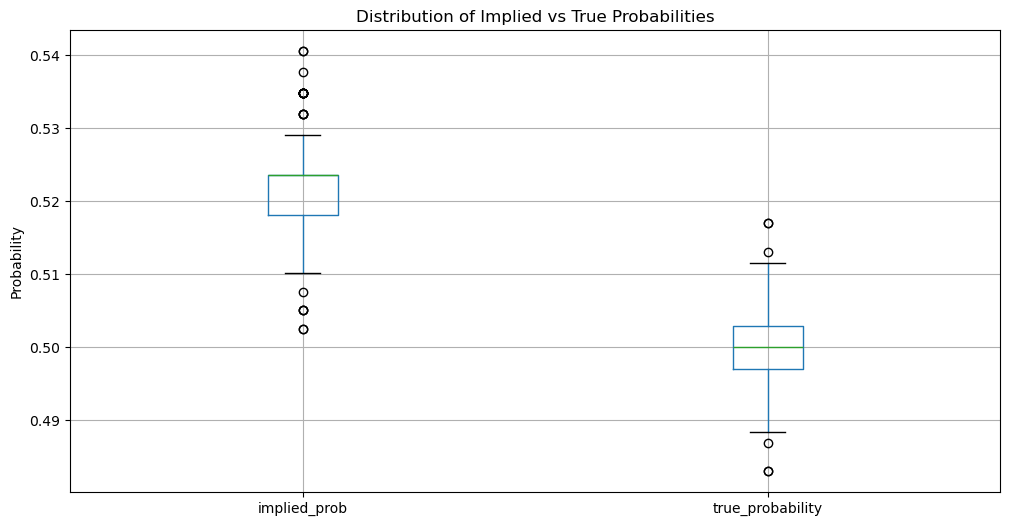

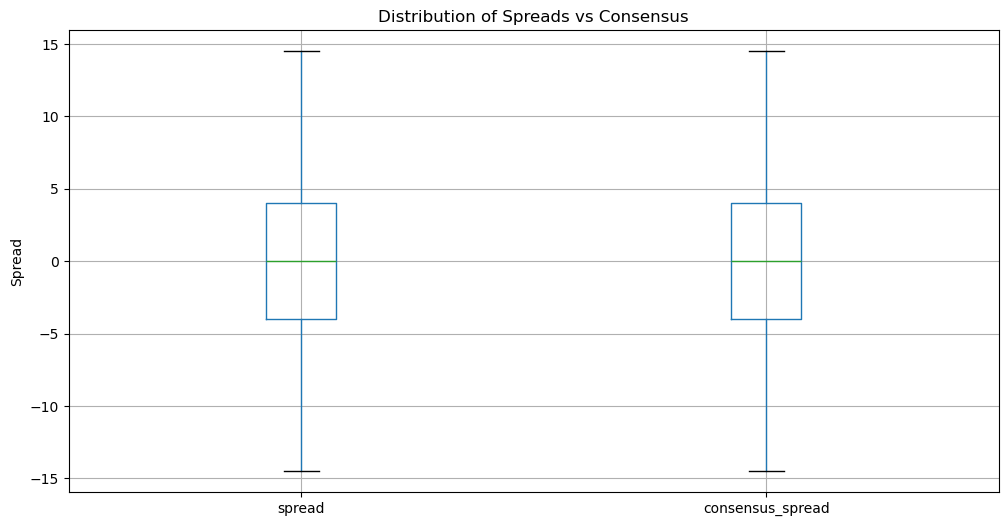

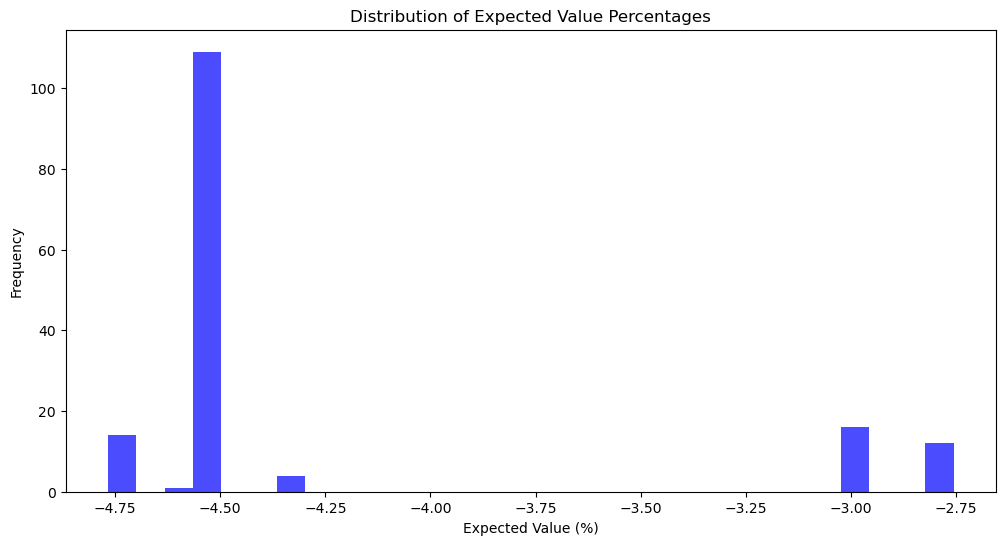

In [12]:
def create_visualizations(df):
    import matplotlib.pyplot as plt
    
    # 1. Implied Probabilities Distribution
    plt.figure(figsize=(12, 6))
    df.boxplot(column=['implied_prob', 'true_probability'], grid=True)
    plt.title('Distribution of Implied vs True Probabilities')
    plt.ylabel('Probability')
    plt.show()
    
    # 2. Spread Distribution
    plt.figure(figsize=(12, 6))
    df.boxplot(column=['spread', 'consensus_spread'], grid=True)
    plt.title('Distribution of Spreads vs Consensus')
    plt.ylabel('Spread')
    plt.show()
    
    # 3. EV Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df['ev_percentage'], bins=30, alpha=0.7, color='blue')
    plt.title('Distribution of Expected Value Percentages')
    plt.xlabel('Expected Value (%)')
    plt.ylabel('Frequency')
    plt.show()

# Run visualizations
if 'df' in locals():
    create_visualizations(df)
else:
    print("Please run the data collection first")

In [13]:
def display_detailed_analysis(df):
    print("\n=== DETAILED BETTING ANALYSIS ===\n")
    
    # Summary statistics for each game
    print("GAME SUMMARIES")
    print("-" * 80)
    for game_id in df['game_id'].unique():
        game_data = df[df['game_id'] == game_id]
        home_team = game_data['home_team'].iloc[0]
        away_team = game_data['away_team'].iloc[0]
        
        print(f"\n{home_team} vs {away_team}")
        print(f"{'='*40}")
        
        # Home team stats
        home_data = game_data[game_data['team'] == home_team]
        print(f"\nHOME ({home_team}):")
        print(f"Spread Range: {home_data['spread'].min():.1f} to {home_data['spread'].max():.1f}")
        print(f"Implied Prob: {home_data['implied_prob'].mean()*100:.1f}%")
        print(f"Best Odds: {home_data['decimal_odds'].max():.2f}")
        print(f"EV%: {home_data['ev_percentage'].mean():.1f}%")
        
        # Away team stats
        away_data = game_data[game_data['team'] == away_team]
        print(f"\nAWAY ({away_team}):")
        print(f"Spread Range: {away_data['spread'].min():.1f} to {away_data['spread'].max():.1f}")
        print(f"Implied Prob: {away_data['implied_prob'].mean()*100:.1f}%")
        print(f"Best Odds: {away_data['decimal_odds'].max():.2f}")
        print(f"EV%: {away_data['ev_percentage'].mean():.1f}%")
    
    # Best value bets
    print("\n\nBEST VALUE BETS (Positive Adjusted EV)")
    print("-" * 80)
    best_bets = df[df['adjusted_ev'] > 0].sort_values('adjusted_ev', ascending=False)
    if not best_bets.empty:
        for _, bet in best_bets.iterrows():
            print(f"\nTeam: {bet['team']}")
            print(f"Bookmaker: {bet['bookmaker']}")
            print(f"Spread: {bet['spread']:.1f}")
            print(f"Odds: {bet['decimal_odds']:.2f}")
            print(f"EV%: {bet['ev_percentage']:.1f}%")
            print(f"Potential Profit (per $100): ${bet['potential_profit']:.2f}")
    else:
        print("No positive EV bets found")
    
    # Bookmaker analysis
    print("\n\nBOOKMAKER ANALYSIS")
    print("-" * 80)
    bookmaker_stats = df.groupby('bookmaker').agg({
        'spread_diff_from_consensus': ['mean', 'std'],
        'removed_vig': 'mean'
    }).round(3)
    print("\nAverage deviation from consensus and vig by bookmaker:")
    print(bookmaker_stats)

# Run the analysis
if 'df' in locals():
    display_detailed_analysis(df)
else:
    print("Please run the data collection first")


=== DETAILED BETTING ANALYSIS ===

GAME SUMMARIES
--------------------------------------------------------------------------------

Charlotte Hornets vs Los Angeles Clippers

HOME (Charlotte Hornets):
Spread Range: 12.5 to 13.0
Implied Prob: 52.2%
Best Odds: 1.95
EV%: -4.3%

AWAY (Los Angeles Clippers):
Spread Range: -13.0 to -12.5
Implied Prob: 52.3%
Best Odds: 1.96
EV%: -4.3%

Detroit Pistons vs Dallas Mavericks

HOME (Detroit Pistons):
Spread Range: 1.0 to 1.5
Implied Prob: 52.5%
Best Odds: 1.95
EV%: -4.4%

AWAY (Dallas Mavericks):
Spread Range: -1.5 to -1.0
Implied Prob: 52.1%
Best Odds: 1.98
EV%: -4.4%

Toronto Raptors vs Chicago Bulls

HOME (Toronto Raptors):
Spread Range: -4.0 to -3.5
Implied Prob: 52.1%
Best Odds: 1.97
EV%: -4.4%

AWAY (Chicago Bulls):
Spread Range: 3.5 to 4.0
Implied Prob: 52.5%
Best Odds: 1.98
EV%: -4.4%

Philadelphia 76ers vs Denver Nuggets

HOME (Philadelphia 76ers):
Spread Range: 9.5 to 9.5
Implied Prob: 51.7%
Best Odds: 1.99
EV%: -4.4%

AWAY (Denver Nugg

In [14]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

class BettingAnalyzer:
    def __init__(self):
        # Check if GPU is available
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Initialize model and tokenizer with an open-access model
        self.model_name = "facebook/opt-350m"  # This is a smaller, open model
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            device_map="auto",
            load_in_8bit=True  # This reduces memory usage
        )
        
    def generate_analysis(self, data, analysis_type="general"):
        """
        Generate AI-powered analysis of betting data using Hugging Face model
        """
        prompts = {
            "general": """Analyze these sports betting data and provide key insights:
                        Focus on value opportunities, risks, and actionable recommendations.
                        
                        Data:
                        """,
            
            "odds": """Analyze these betting odds and probability distributions:
                      Focus on market efficiency, mispricing, and potential edges.
                      
                      Data:
                      """,
            
            "trends": """Analyze these betting trends and patterns:
                        Focus on significant movements, correlations, and predictive factors.
                        
                        Data:
                        """
        }
        
        base_prompt = prompts.get(analysis_type, prompts["general"])
        full_prompt = f"<|endoftext|>System: You are an expert sports betting analyst.\nUser: {base_prompt}\n{data}\nAssistant:"
        
        try:
            # Generate with more conservative parameters
            inputs = self.tokenizer(full_prompt, return_tensors="pt", truncation=True, max_length=1024).to(self.device)
            outputs = self.model.generate(
                **inputs,
                max_length=1536,  # Reduced from 2048
                temperature=0.7,
                do_sample=True,
                top_p=0.95,
                num_return_sequences=1,
                pad_token_id=self.tokenizer.eos_token_id
            )
            
            response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            response = response.split("Assistant:")[-1].strip()
            
            return response
            
        except Exception as e:
            return f"Error generating analysis: {str(e)}"

# Usage example remains the same...

In [15]:
if 'df' in locals():
    # Initialize analyzer if not already done
    if 'analyzer' not in locals():
        analyzer = BettingAnalyzer()
    
    # Generate analysis for odds data
    odds_data = df.groupby(['game_id', 'home_team', 'away_team', 'team']).agg({
        'implied_prob': ['mean', 'min', 'max'],
        'true_probability': 'mean',
        'removed_vig': 'mean'
    }).round(4).to_string()
    
    print("\n=== AI BETTING ANALYSIS ===")
    print("-" * 50)
    analysis = analyzer.generate_analysis(odds_data, "odds")
    print(analysis)
    
    # Generate analysis for overall betting opportunities
    betting_data = df[df['adjusted_ev'] > -0.05].sort_values('adjusted_ev', ascending=False)[
        ['home_team', 'away_team', 'team', 'spread', 'decimal_odds', 
         'ev_percentage', 'adjusted_ev', 'consensus_strength']
    ].to_string()
    
    print("\n=== AI VALUE OPPORTUNITIES ANALYSIS ===")
    print("-" * 50)
    analysis = analyzer.generate_analysis(betting_data, "general")
    print(analysis)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`